In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import ale_py
import imageio
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
# Register ALE environments
gym.register_envs(ale_py)

# --- Configuration ---
NUM_ENVS = 16          # Group Size (G)
NUM_STEPS = 1024        # Steps per rollout (Memory constraint for high-res)
NUM_GENS = 150         # Total Generations
LEARNING_RATE = 1e-4   # Matches original TF script
CLIP_EPS = 0.2         # Matches original TF script (Standard GRPO/PPO clip)
BATCH_SIZE = 32       # Batch size for optimization
UPDATE_EPOCHS = 3     # Matches original TF script
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# os.makedirs("grpo_checkpoints", exist_ok=True)

In [3]:
# --- Dataset ---
class GRPODataset(Dataset):
    def __init__(self, obs, act, lps, adv, device):
        self.obs = obs # uint8 numpy
        self.act = torch.tensor(act, dtype=torch.long, device=device)
        self.lps = torch.tensor(lps, dtype=torch.float32, device=device)
        self.adv = torch.tensor(adv, dtype=torch.float32, device=device)
        self.device = device

    def __len__(self):
        return len(self.obs)

    def __getitem__(self, idx):
        o = self.obs[idx]
        o_tensor = torch.tensor(o, dtype=torch.float32, device=self.device)
        o_tensor = o_tensor.permute(2, 0, 1) / 255.0
        return o_tensor, self.act[idx], self.lps[idx], self.adv[idx]

In [4]:
# --- Model (Actor Only - No Critic) ---
# Matches Implementation A's 5-Layer High-Res Architecture
class Actor(nn.Module):
    def __init__(self, num_actions):
        super(Actor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2), nn.ReLU(),
            nn.Flatten()
        )
        
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 210, 160)
            flat_size = self.features(dummy).shape[1]

        self.head = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )
        # Initialize weights orthogonally
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            module.bias.data.fill_(0.0)

    def forward(self, x):
        x = self.features(x)
        return self.head(x)

In [5]:
# --- Rollout ---
def rollout(env, model, num_steps, last_obs=None, device='cpu'):
    if last_obs is None:
        obs, info = env.reset()
    else:
        obs = last_obs

    obs_buf = np.zeros((num_steps, NUM_ENVS, 210, 160, 3), dtype=np.uint8)
    act_buf = np.zeros((num_steps, NUM_ENVS), dtype=np.int32)
    lp_buf  = np.zeros((num_steps, NUM_ENVS), dtype=np.float32)
    rew_buf = np.zeros((num_steps, NUM_ENVS), dtype=np.float32)
    
    model.eval()
    with torch.no_grad():
        for step in range(num_steps):
            # Standard FP32 forward pass
            obs_norm = obs.astype(np.float32) / 255.0
            obs_tensor = torch.tensor(obs_norm, dtype=torch.float32, device=device).permute(0, 3, 1, 2)
            
            logits = model(obs_tensor)
            dist = Categorical(logits=logits)
            actions = dist.sample()
            log_probs = dist.log_prob(actions)

            nxt, reward, terminated, truncated, _ = env.step(actions.cpu().numpy())
            
            obs_buf[step] = obs
            act_buf[step] = actions.cpu().numpy()
            lp_buf[step]  = log_probs.cpu().numpy()
            rew_buf[step] = reward
            
            obs = nxt

    return obs_buf, act_buf, lp_buf, rew_buf, obs

In [6]:
# --- GRPO Advantage Calculation ---
def compute_grpo_advantages(rewards):
    """
    rewards: (Steps, Envs)
    
    GRPO Logic:
    1. Sum rewards for each environment (trajectory return).
    2. Compute Mean and Std of these returns across the group (Envs).
    3. Advantage = (Return - Mean) / (Std + epsilon).
    4. Broadcast this advantage to every step in the trajectory.
    """
    # 1. Total Reward per Env
    total_return = np.sum(rewards, axis=0) # Shape: (Envs,)
    
    # 2. Group Stats
    group_mean = np.mean(total_return)
    group_std = np.std(total_return) + 1e-8
    
    # 3. Normalize (Group Relative Advantage)
    advantages = (total_return - group_mean) / group_std # Shape: (Envs,)
    
    # 4. Broadcast to steps: (Steps, Envs)
    advantages = np.repeat(advantages[None, :], repeats=rewards.shape[0], axis=0)
    
    return advantages, total_return

In [7]:
# --- Training Step ---
def train_step(model, optimizer, batch):
    obs, act, old_lps, adv = batch
    
    model.train()
    
    # Standard Forward Pass
    logits = model(obs)
    dist = Categorical(logits=logits)
    new_lps = dist.log_prob(act)
    entropy = dist.entropy().mean()

    # PPO-style Clipping with GRPO advantages
    ratio = torch.exp(new_lps - old_lps)
    surr1 = ratio * adv
    surr2 = torch.clamp(ratio, 1.0 - CLIP_EPS, 1.0 + CLIP_EPS) * adv
    
    # Loss Function
    ppo_loss = -torch.min(surr1, surr2).mean()
    policy_loss = ppo_loss - 0.01 * entropy

    # Standard Backward Pass
    optimizer.zero_grad()
    policy_loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    with torch.no_grad():
        approx_kl = (old_lps - new_lps).mean()
        clipped = (torch.abs(ratio - 1.0) > CLIP_EPS).float().mean()
        avg_probs = torch.exp(new_lps).mean()

    return ppo_loss.item(), entropy.item(), policy_loss.item(), approx_kl.item(), clipped.item(), avg_probs.item()

In [8]:
# --- Main Loop ---
def main():
    print(f"Starting GRPO Training on {DEVICE} (Standard FP32)")
    print(f"Architecture: 5-Layer CNN (No Critic)")
    print(f"Group Size (Num Envs): {NUM_ENVS}")
    
    env = gym.make_vec('ALE/Galaxian-v5', frameskip=4, num_envs=NUM_ENVS, vectorization_mode='sync')
    
    model = Actor(env.single_action_space.n).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    current_obs = None
    
    # History for plotting
    avg_rewards = []
    max_rewards = []

    for gen in range(NUM_GENS):
        # 1. Rollout
        obs, act, lps, rew, current_obs = rollout(
            env, model, NUM_STEPS, last_obs=current_obs, device=DEVICE
        )

        # 2. GRPO Advantage
        adv, total_returns = compute_grpo_advantages(rew)
        
        # Metrics for this generation
        avg_ret = np.mean(total_returns)
        max_ret = np.max(total_returns)
        avg_rewards.append(avg_ret)
        max_rewards.append(max_ret)

        # 3. Dataset
        b_obs = obs.reshape(-1, 210, 160, 3)
        b_act = act.reshape(-1)
        b_lps = lps.reshape(-1)
        b_adv = adv.reshape(-1)

        dataset = GRPODataset(b_obs, b_act, b_lps, b_adv, DEVICE)
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False)

        # 4. Train
        metrics = []
        for _ in range(UPDATE_EPOCHS):
            for batch in dataloader:
                metrics.append(train_step(model, optimizer, batch))
        
        # Averages
        m = np.mean(metrics, axis=0)
        
        print(f"Gen {gen:3d} | Reward: {avg_ret:6.2f} | PPO Loss: {m[0]:6.3f} | "
              f"Ent: {m[1]:5.3f} | KL: {m[3]:5.3f} | Clip: {m[4]:4.2f}")

    # Save
    torch.save(model.state_dict(), "grpo_atari_actor.pth")
    
    # Plotting
    print("Generating Training Plot...")
    epochs = range(1, NUM_GENS + 1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, avg_rewards, '*-b')
    plt.title('Average Reward per Gen')
    plt.xlabel('Gen')
    plt.subplot(1, 2, 2)
    plt.plot(epochs, max_rewards, '--r')
    plt.title('Max Reward per Gen')
    plt.xlabel('Gen')
    plt.tight_layout()
    plt.savefig('grpo_training_plot.png')
    
    # GIF Generation
    print("Generating GIF...")
    obs, _, _, _, _ = rollout(env, model, num_steps=1024, last_obs=None, device=DEVICE)
    to_render = obs[:, 0, ...] 
    imageio.mimsave('grpo_atari.gif', to_render, fps=30, loop=0)
    print("Done.")

Starting GRPO Training on cuda (Standard FP32)
Architecture: 5-Layer CNN (No Critic)
Group Size (Num Envs): 16


A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


Gen   0 | Reward: 1301.25 | PPO Loss: -0.004 | Ent: 1.763 | KL: 0.007 | Clip: 0.06
Gen   1 | Reward: 1089.38 | PPO Loss: -0.006 | Ent: 1.764 | KL: 0.006 | Clip: 0.06
Gen   2 | Reward: 1056.25 | PPO Loss: -0.007 | Ent: 1.755 | KL: 0.006 | Clip: 0.08
Gen   3 | Reward: 935.00 | PPO Loss: -0.008 | Ent: 1.755 | KL: 0.008 | Clip: 0.08
Gen   4 | Reward: 878.12 | PPO Loss: -0.008 | Ent: 1.752 | KL: 0.006 | Clip: 0.07
Gen   5 | Reward: 1007.50 | PPO Loss: -0.009 | Ent: 1.753 | KL: 0.006 | Clip: 0.08
Gen   6 | Reward: 993.12 | PPO Loss: -0.010 | Ent: 1.733 | KL: 0.006 | Clip: 0.08
Gen   7 | Reward: 946.25 | PPO Loss: -0.008 | Ent: 1.729 | KL: 0.007 | Clip: 0.08
Gen   8 | Reward: 856.25 | PPO Loss: -0.011 | Ent: 1.731 | KL: 0.008 | Clip: 0.10
Gen   9 | Reward: 986.25 | PPO Loss: -0.010 | Ent: 1.728 | KL: 0.007 | Clip: 0.08
Gen  10 | Reward: 996.88 | PPO Loss: -0.010 | Ent: 1.704 | KL: 0.008 | Clip: 0.09
Gen  11 | Reward: 913.12 | PPO Loss: -0.011 | Ent: 1.702 | KL: 0.009 | Clip: 0.09
Gen  12 | Re

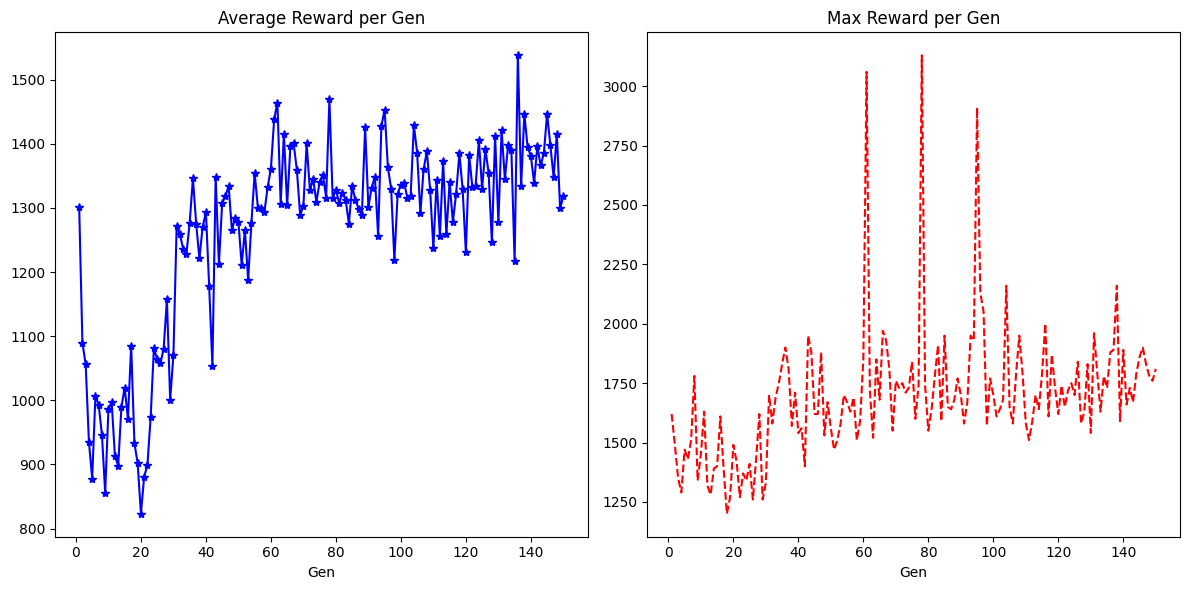

In [9]:
if __name__ == "__main__":
    main()